- Barry Saliou
- Zhang Zhile

# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [3]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ int(h), int(s), int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather than the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantized interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For an image value v=1, the function will return K-1.

In [4]:
def quantize(v, K):
    # Vérifier que la valeur v est dans la plage [0, 1]
    if v < 0 or v > 1:
        raise ValueError("La valeur v doit être dans la plage [0, 1]")

    # Calculer la taille de chaque intervalle
    interval_size = 1 / K

    # Quantifier la valeur v en fonction de l'intervalle
    quantized_interval = int(v / interval_size)

    # Retourner le résultat en s'assurant que la valeur est dans la plage correcte
    return min(quantized_interval, K-1)

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
print(h)
assert (h == 32*np.ones((8))).all()

[32. 32. 32. 32. 32. 32. 32. 32.]


2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixels for each quantification bin (iH, iS, iV)

In [5]:
def quantizeImage(I, Nh, Ns, Nv):
    n, m, c = I.shape
    Iq = np.zeros((n, m, 3), dtype=int)
    histo = np.zeros((Nh, Ns, Nv), dtype=int)

    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            hq = quantize(h, Nh)
            sq = quantize(s, Ns)
            vq = quantize(v, Nv)
            Iq[i, j, :] = np.array([hq, sq, vq])
            histo[hq, sq, vq] += 1

    return Iq, histo

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [6]:
def NormalizeHistL2(histo):
    """ Array -> Array"""
    l2_norm = np.linalg.norm(histo, 2)
    normalized_histo = histo / l2_norm
    return normalized_histo

4) Test the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


In [35]:
def hsv_image(name,H,S,V):
    PathImage = './Base/' 
    nom = name  

    # quantization parameters
    nH = H
    nS = S
    nV = V


    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    plt.figure();
    plt.imshow(I);
    plt.title("Image original")
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    plt.figure();
    plt.title("Quantized Image")
    viewQuantizedImage(Iq , palette2)

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = NormalizeHistL2(histo)

    plt.figure()
    plt.plot(histo)
    plt.title("hist")
    plt.show()

    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
    

    print("Top 5 colors :")
    display5mainColors(histo, palette)

    print(hsv_most_prevalent)

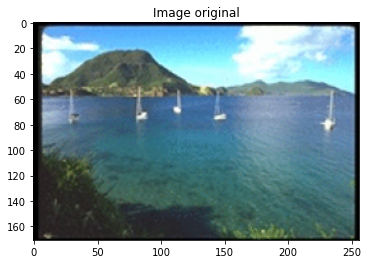

239.0625


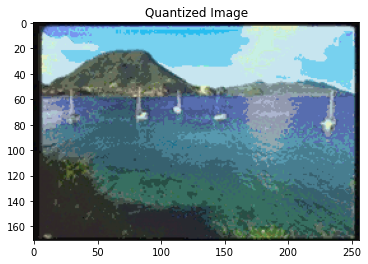

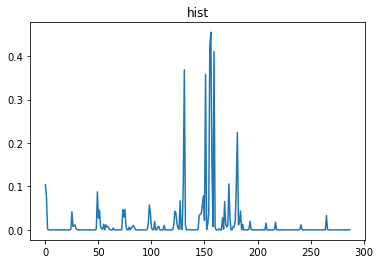

Top 5 colors :


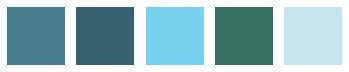

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [36]:
hsv_image('paysages67.png', 12,3,8)

5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

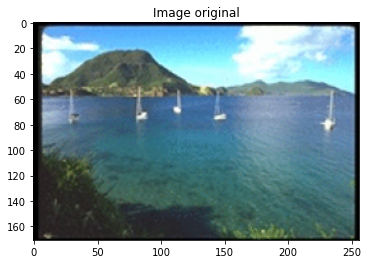

229.5


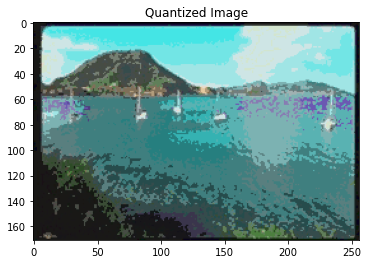

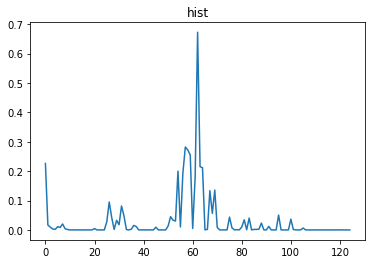

Top 5 colors :


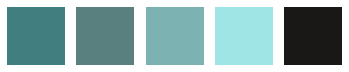

[(2, 2, 2), (2, 1, 2), (2, 1, 3), (2, 1, 4), (0, 0, 0)]


In [27]:
hsv_image('paysages67.png', 5,5,5)

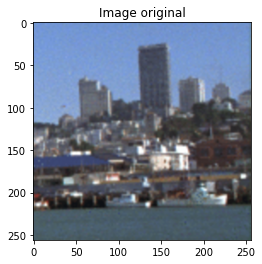

229.5


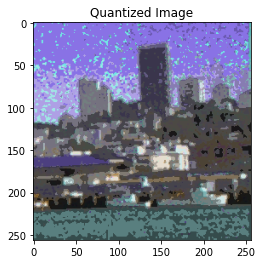

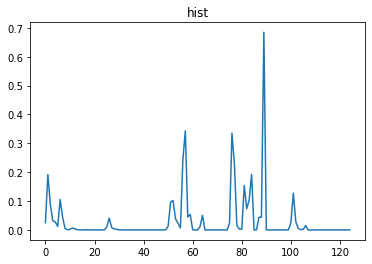

Top 5 colors :


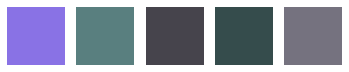

[(3, 2, 4), (2, 1, 2), (3, 0, 1), (2, 1, 1), (3, 0, 2)]


In [28]:
hsv_image('Paysages81.png', 5,5,5)

6) What can you say about the results?

Your answer: ............

## Exercise 2: Similarity between images: 

In this exercise, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [8]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = True # Set to False to compute the histogramm database

if not bcomputed:
    listImage = os.listdir(pathImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(NormalizeHistL2(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every image in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [40]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

### you code below
def similarity(listHisto) :
    # listHisto : liste des histogrammes des images de la base 
    taille = listHisto.shape[0] # nombre d'images dans la base

    # Initialisation de la matrice de similarité
    matrix = np.zeros((taille, taille)) 

    # Calcul de la matrice de similarité
    for i, h1 in enumerate(listHisto): 
        for j, h2 in enumerate(listHisto) : 
            matrix[i, j] = np.dot(h1, h2)
    return matrix   

2. Display the matrix `S`  as an image. What can we say about this it ?

In [51]:
S = similarity(listHisto)

[Text(0.5, 1.0, 'SmilarityMat')]

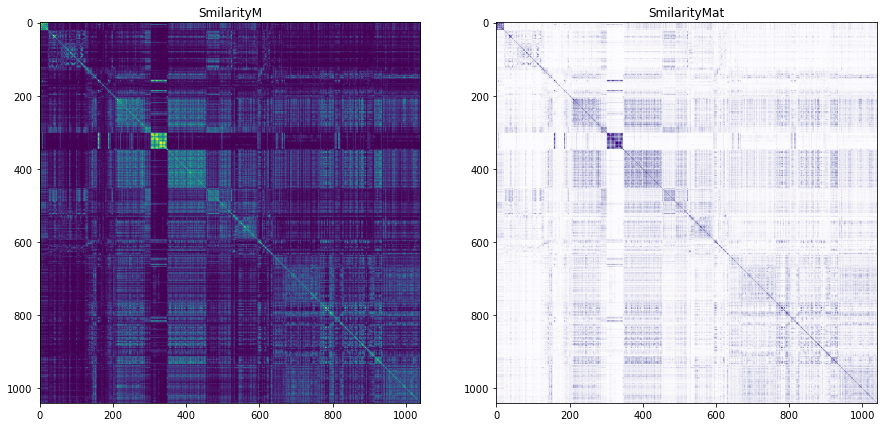

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(S)
ax[0].set(title = 'SmilarityM')

ax[1].imshow(S,cmap="Purples")
ax[1].set(title = 'SmilarityMat')


<font color="green">
    
The first image is the original similarity matrix, and in the second image, we adjusted the color display to better highlight the correlations between histograms. In the second image, the similarity between histograms is represented by the purple color value. A higher purple color value indicates greater similarity, whereas a lower value indicates less similarity. This conclusion is drawn based on the values along the diagonal because we know that the diagonal represents the similarity of each histogram to itself, so the values on the diagonal should be 100%, displayed as a very high purple color value. Therefore, we can infer that a higher purple color value indicates a closer similarity between histograms.

Additionally, from the image, we can observe recurring purple square matrices. This is because in our base image library, images of each category are arranged consecutively. For example, images 80 to 120 belong to the “paysage” category. Since the color histograms of images within the same category tend to be similar, they result in a light purple or purple square matrix in the similarity matrix.

</font> 

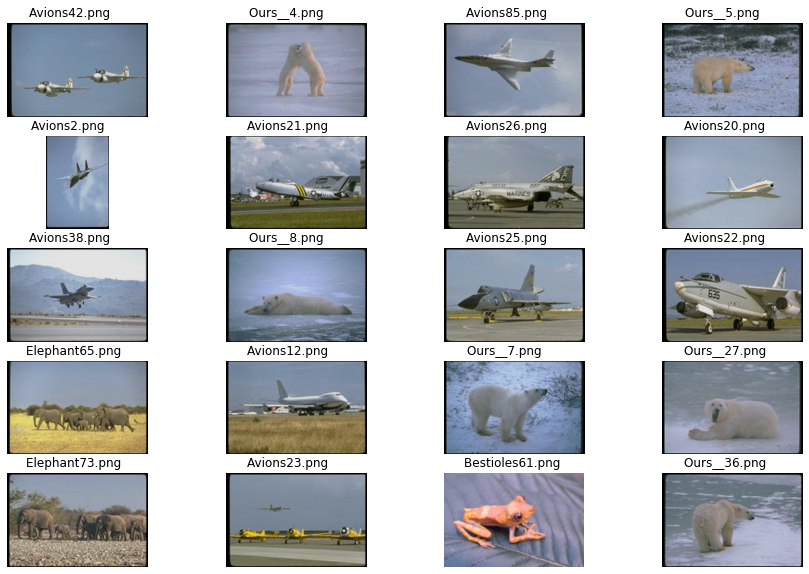

In [48]:
display20bestMatches(S, 60)

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

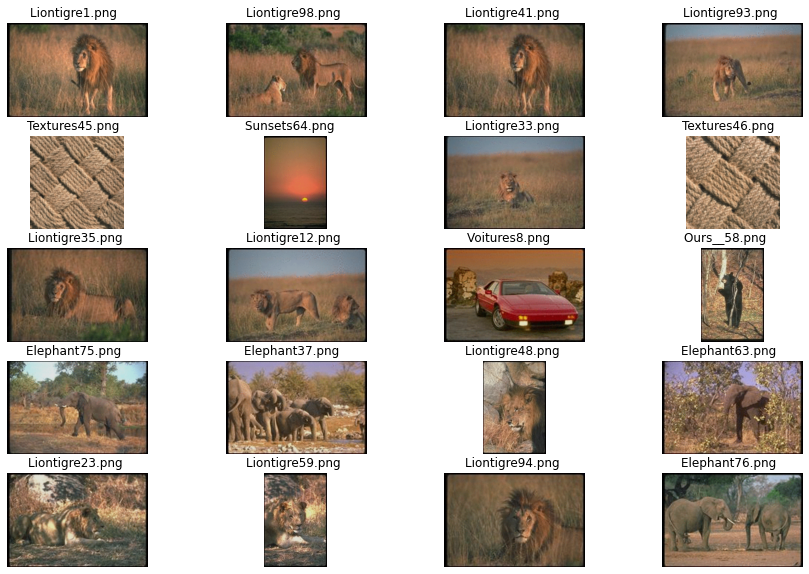

In [16]:
indexQuery = 349

display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

4. Assuming `S` is already computed, generate a random query (an integer in the range $[0, 1030]$), and display the 20 best matches.


Best 20 matches of image 'Textures103.png'


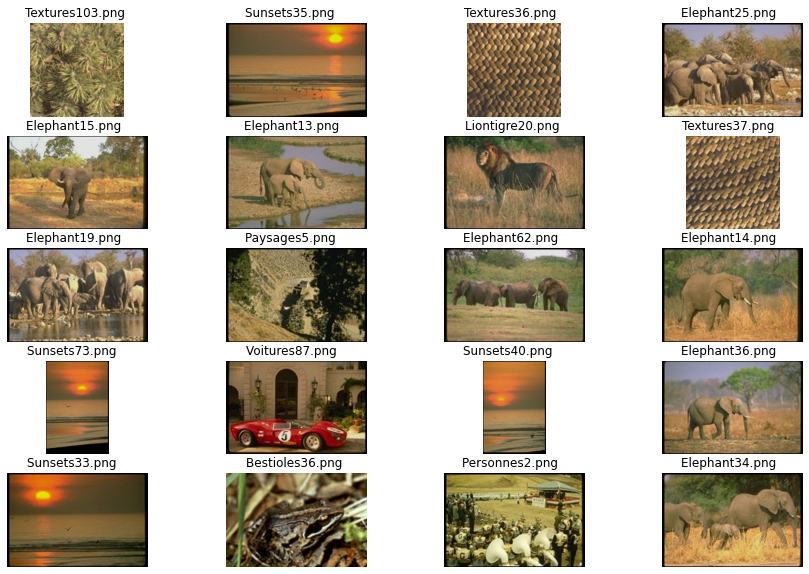

In [49]:
import random

random.seed(42)
indexQuery = np.random.randint(0, 1030)
print(f"Best 20 matches of image '{listImage[indexQuery].strip()}'")
display20bestMatches(S, indexQuery)

5. What can you say about the results? What are the limitations and the advantages of this method?

<font color="green">

The most matching images selected from these choices reveal that using color similarity as a means to extract feature descriptors or classify images has limitations. For instance, when attempting to select images related to "liontiger," it becomes apparent that the results include images of elephants, cars, fabric, and even sunsets. This is because these images share a common earthy-yellow background color, which, in terms of color, resembles the wild background of the "liontiger" images. Consequently, they are chosen as the top 20 best matching images. However, if our goal is specifically to identify all images of lions and tigers, then these images would be incorrect selections, affecting the accuracy of classification or feature selection.

Therefore, the approach to selection should align with the specific objective. If the aim is solely to choose images with similar colors, then this method proves highly accurate.
    
</font> 